<a href="https://colab.research.google.com/github/sneha1012/knowledge-graph-completion/blob/main/Graph_Attention_Netwworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Graph attention Networks for knowledge completion graphs using Pytorch**

Graph Attention Networks (GAT) Graph Attention Networks (GAT) introduce an attention mechanism that allows nodes to focus on their most informative neighbors, rather than treating all neighbors equally. This is particularly useful for graph-structured data where the importance of neighbors can vary significantly.

we are using **Freebase 15k-237** Dataset present.
**Origin**: Derived from Freebase and contains a subset of the FB15K dataset. **Textual Mentions**: Derived from 200 million sentences from the ClueWeb12 corpus coupled with Freebase entity mention annotations.

In [7]:
!pip install torch torchvision networkx matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [8]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Data for GATS/train.txt'


with open(file_path, 'r') as file:
    data = file.read()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Dictionaries to map entities and relations to unique integer IDs
entity2id = {}
relation2id = {}

# Lists to store triples
triples = []

# Read the file and process the data
with open(file_path, 'r') as f:
    for line in f:
        s, p, o = line.strip().split('\t')

        # Assign unique IDs to entities and relations
        if s not in entity2id:
            entity2id[s] = len(entity2id)
        if o not in entity2id:
            entity2id[o] = len(entity2id)
        if p not in relation2id:
            relation2id[p] = len(relation2id)

        # Store the triples
        triples.append((entity2id[s], relation2id[p], entity2id[o]))

In [10]:
# Defining our GAT Model
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(2*out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = self.W(input)
        N = h.size()[0]
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(self.a(a_input).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return x

In [11]:
num_entities = len(entity2id)  # Number of unique entities in your dataset
embedding_dim = 128  # Dimension of the embeddings

# Create random initial embeddings for each entity
initial_entity_embeddings = np.random.rand(num_entities, embedding_dim)
initial_entity_embeddings_tensor = torch.tensor(initial_entity_embeddings, dtype=torch.float32)

In [12]:
# Defining the matrix
adjacency_matrix = torch.zeros((num_entities, num_entities))

for s, _, o in triples:
    adjacency_matrix[s][o] = 1
    adjacency_matrix[o][s] = 1  # Assuming the graph is undirected

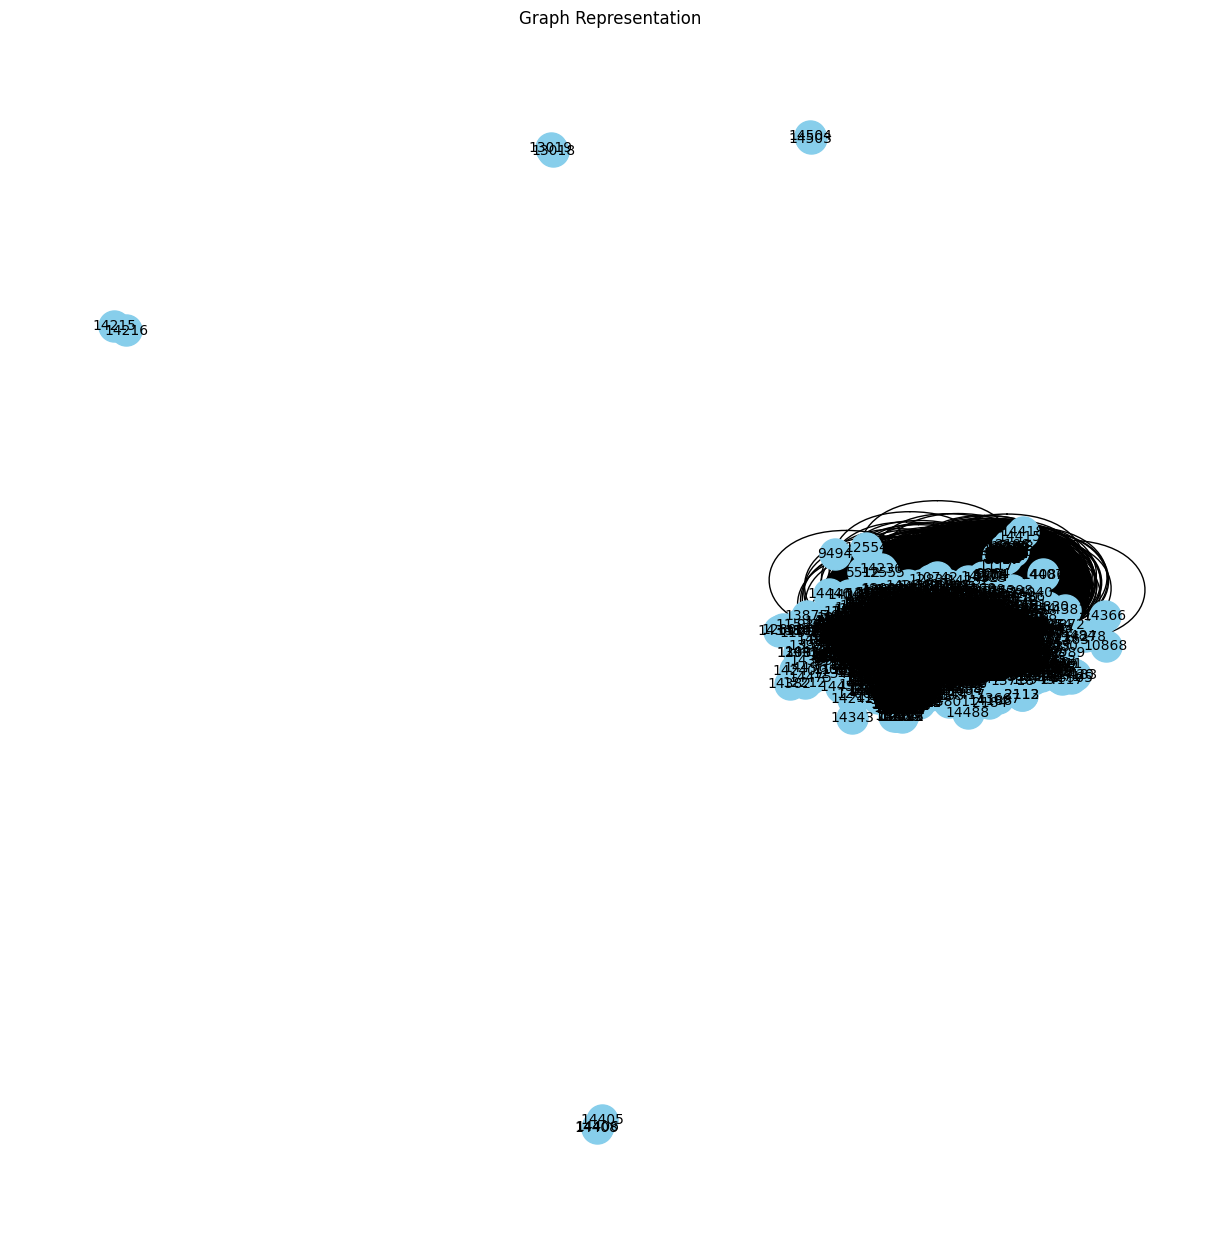

In [14]:
G = nx.Graph()
for s, p, o in triples:
    G.add_edge(s, o, label=p)

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="k")
plt.title("Graph Representation")
plt.show()


In [ ]:
# Hyperparameters
nhid = 8  # Number of hidden units
nclass = embedding_dim  # Output class, this can be adjusted considering our task we tring to achieve
dropout = 0.6  # Dropout rate
alpha = 0.2  # Alpha for the leaky_relu
nheads = 8  # Number of head attentions

# Initialize the GAT model and optimizer
model = GAT(nfeat=embedding_dim, nhid=nhid, nclass=nclass, dropout=dropout, alpha=alpha, nheads=nheads)
optimizer = Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Placeholder for the labels (you'll need to define this based on your task)
labels = torch.tensor(initial_entity_embeddings, dtype=torch.float32)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(initial_entity_embeddings_tensor, adjacency_matrix)

    # Computing the loss here
    loss_train = F.mse_loss(output, labels)  # Using MSE loss as a placeholder
    loss_train.backward()
    optimizer.step()


In [ ]:
# Extract embeddings after training
embeddings = model(initial_entity_embeddings_tensor, adjacency_matrix).detach().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("2D t-SNE representation of embeddings")
plt.show()